In [30]:
spark.stop()

In [31]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Notebook") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY")\
    .getOrCreate()

In [32]:
base_path = "hdfs://namenode:9000/data/silver/ecom"

df_customers = spark.read.option(
    "header", "true").csv(f"{base_path}/customers")
df_geolocation = spark.read.option(
    "header", "true").csv(f"{base_path}/geolocation")
df_order_items = spark.read.option(
    "header", "true").csv(f"{base_path}/order_items")
df_order_payments = spark.read.option(
    "header", "true").csv(f"{base_path}/order_payments")
df_order_reviews = spark.read.option(
    "header", "true").csv(f"{base_path}/order_reviews")
df_orders = spark.read.option("header", "true").csv(f"{base_path}/orders")
df_product_category_name_translations = spark.read.option(
    "header", "true").csv(f"{base_path}/product_category_name_translations")
df_products = spark.read.option("header", "true").csv(f"{base_path}/products")
df_sellers = spark.read.option("header", "true").csv(f"{base_path}/sellers")

In [33]:
df_orders.createOrReplaceTempView("orders")

orders_per_day = spark.sql("""
SELECT
    DATE(order_purchase_timestamp) AS day,
    COUNT(*) AS order_count
FROM orders
GROUP BY day
ORDER BY day
""")

orders_per_day.show(5)

+----------+-----------+
|       day|order_count|
+----------+-----------+
|2016-09-04|          2|
|2016-09-05|          2|
|2016-09-13|          2|
|2016-09-15|          2|
|2016-10-02|          2|
+----------+-----------+
only showing top 5 rows



# Orders by Date

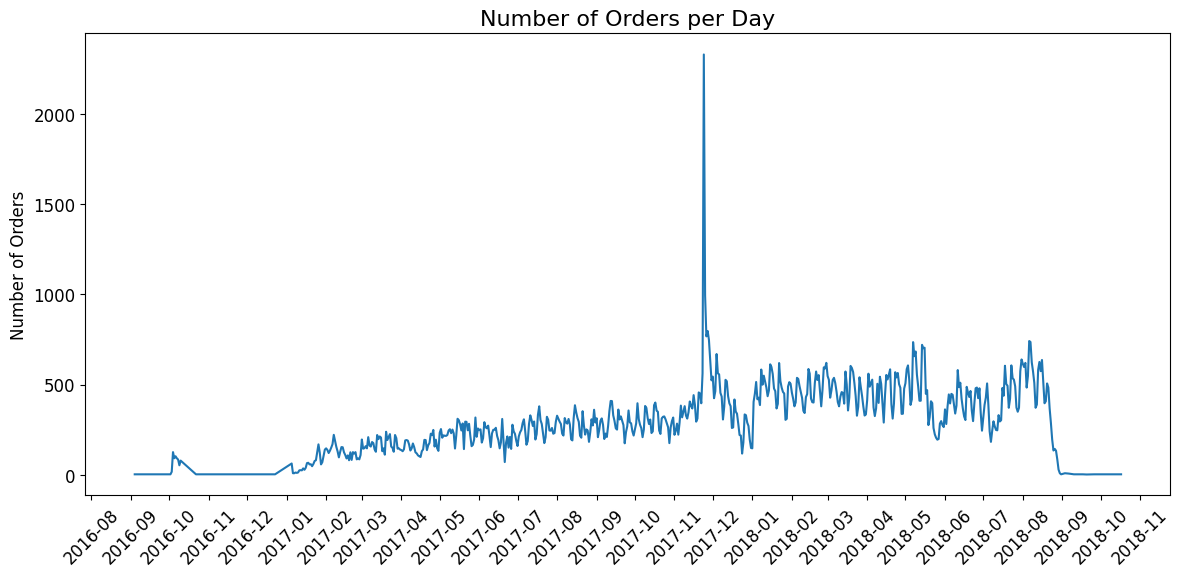

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
df_pandas = orders_per_day.toPandas()

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df_pandas['day']),
         df_pandas['order_count'])
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

# Order by Time of Day & Day of Week

In [35]:

order_day_hour = spark.sql("""
SELECT
    CASE DATE_FORMAT(order_purchase_timestamp, 'u')
        WHEN '1' THEN 'Mon'
        WHEN '2' THEN 'Tue'
        WHEN '3' THEN 'Wed'
        WHEN '4' THEN 'Thu'
        WHEN '5' THEN 'Fri'
        WHEN '6' THEN 'Sat'
        WHEN '7' THEN 'Sun'
    END AS day_of_week_name,
    CAST(DATE_FORMAT(order_purchase_timestamp, 'u') AS INTEGER) AS day_of_week_int,
    CAST(DATE_FORMAT(order_purchase_timestamp, 'HH') AS INTEGER) AS hour
FROM orders
""")

order_day_hour.createOrReplaceTempView("OrderDayHour")

orders_per_day_of_the_week_and_hour = spark.sql(f"""
SELECT
    day_of_week_name,
    {', '.join([f'COUNT(CASE WHEN hour = {i} THEN 1 END) AS `{i}`'
                for i in range(24)])}
FROM OrderDayHour
GROUP BY day_of_week_name, day_of_week_int
ORDER BY day_of_week_int
""")

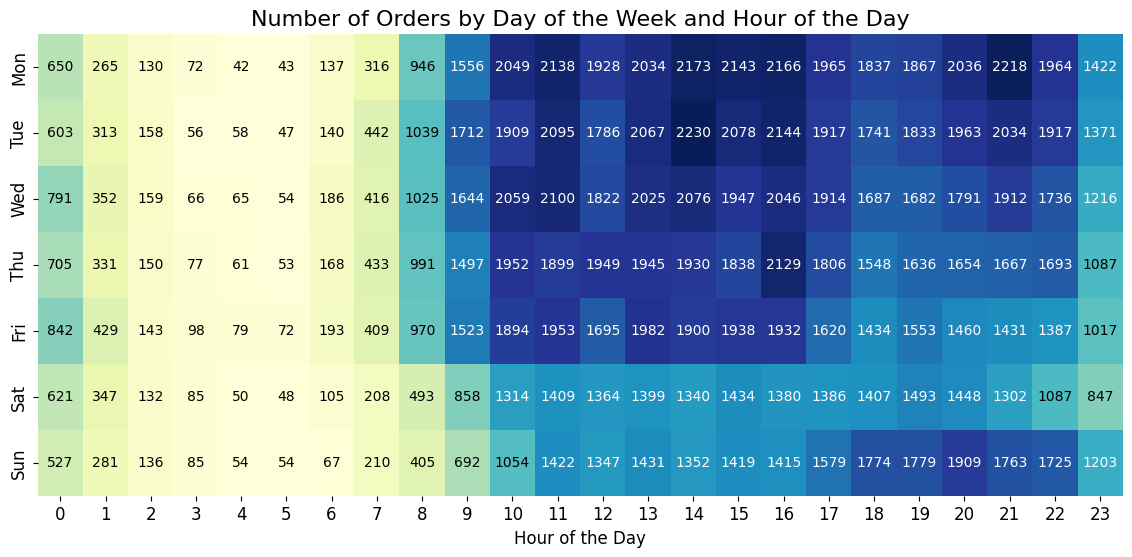

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
df_pandas = orders_per_day_of_the_week_and_hour.toPandas()

df_pandas = df_pandas.set_index('day_of_week_name')


fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df_pandas, cmap='YlGnBu', cbar=False, ax=ax)

mean_orders = df_pandas.mean().mean()

for i in range(len(df_pandas)):
    for j in range(len(df_pandas.columns)):
        text_color = 'white' if df_pandas.iloc[i, j] > mean_orders else 'black'
        ax.text(j + 0.5, i + 0.5, int(df_pandas.iloc[i, j]),
                color=text_color, fontsize=10, ha="center", va="center")

plt.title("Number of Orders by Day of the Week and Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("")
plt.show()

# Order Volume by Cities

In [37]:
df_customers.createOrReplaceTempView("customers")

orders_per_city = spark.sql("""
SELECT 
    customer_city AS customer_city,
    UPPER(customer_city) AS city,
    COUNT(orders.order_id) as city_order_count
FROM 
    customers
    JOIN orders ON customers.customer_id = orders.customer_id
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 10
""")

orders_per_city_reversed = orders_per_city.orderBy("city_order_count")

top_cities = orders_per_city_reversed.toPandas()

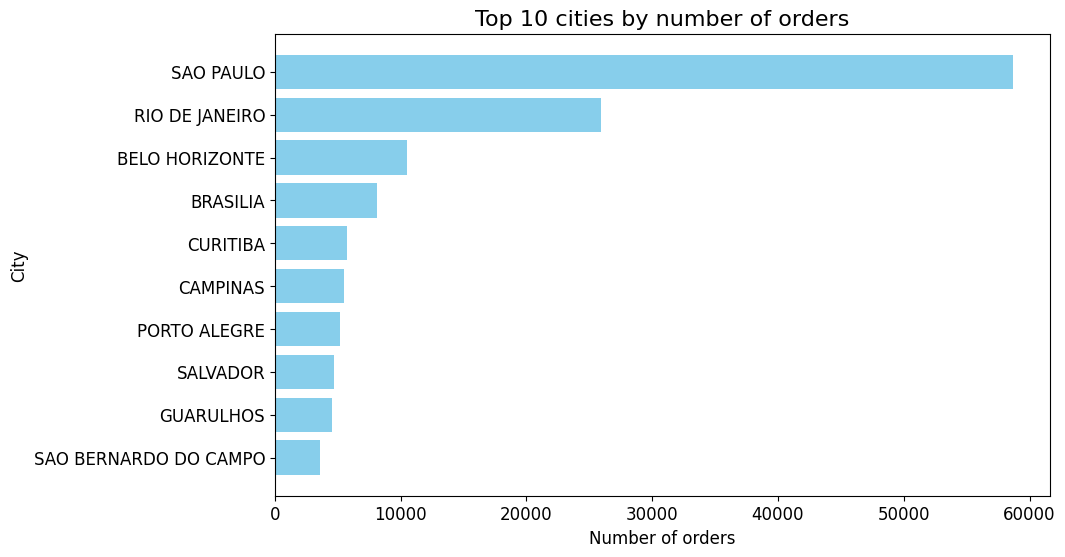

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'], top_cities['city_order_count'], color='skyblue')
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

# Product Cost & Shipping Cost

In [39]:
df_order_items.createOrReplaceTempView("order_items")

order_price_stats = spark.sql("""
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id
)
""")

In [40]:
order_product_and_shipping_costs = spark.sql("""
SELECT
    orders.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    orders
    JOIN order_items ON orders.order_id = order_items.order_id
WHERE order_status = 'delivered'
GROUP BY orders.order_id
""")

df = order_product_and_shipping_costs.toPandas()

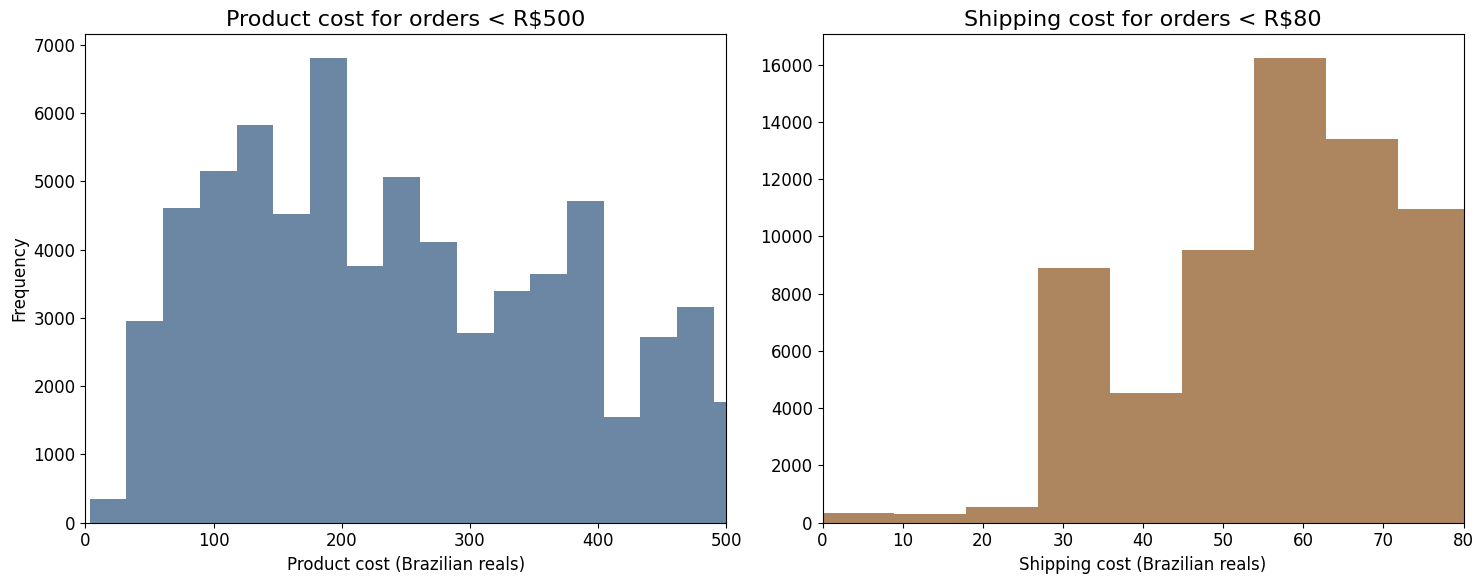

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#6c87a3')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])

plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#ad865f')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Shipping cost (Brazilian reals)')
plt.xlim([0, 80])

plt.tight_layout()
plt.show()

# Sales by Product Category



In [42]:
df_order_items.createOrReplaceTempView("order_items")
df_orders.createOrReplaceTempView("orders")
df_products.createOrReplaceTempView("products")
df_product_category_name_translations.createOrReplaceTempView(
    "product_category_name_translation")

ranked_categories = spark.sql("""
SELECT
    product_category_name_english AS category,
    SUM(price) AS sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS rank
FROM order_items
    JOIN orders ON order_items.order_id = orders.order_id
    JOIN products ON order_items.product_id = products.product_id
    JOIN product_category_name_translation ON products.product_category_name = product_category_name_translation.product_category_name
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
""")

category_sales_summary = spark.sql("""
WITH RankedCategories AS (
    SELECT
        product_category_name_english AS category,
        SUM(price) AS sales,
        RANK() OVER (ORDER BY SUM(price) DESC) AS rank
    FROM order_items
        JOIN orders ON order_items.order_id = orders.order_id
        JOIN products ON order_items.product_id = products.product_id
        JOIN product_category_name_translation ON products.product_category_name = product_category_name_translation.product_category_name
    WHERE order_status = 'delivered'
    GROUP BY product_category_name_english
)
SELECT
    category,
    sales
FROM RankedCategories
WHERE rank <= 18
UNION ALL
SELECT
    'Other categories' AS category,
    SUM(sales) AS sales
FROM RankedCategories
WHERE rank > 18
""")

df = category_sales_summary.toPandas()

24/09/13 20:59:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/13 20:59:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/13 20:59:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/13 20:59:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/13 20:59:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/13 20:59:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/13 2

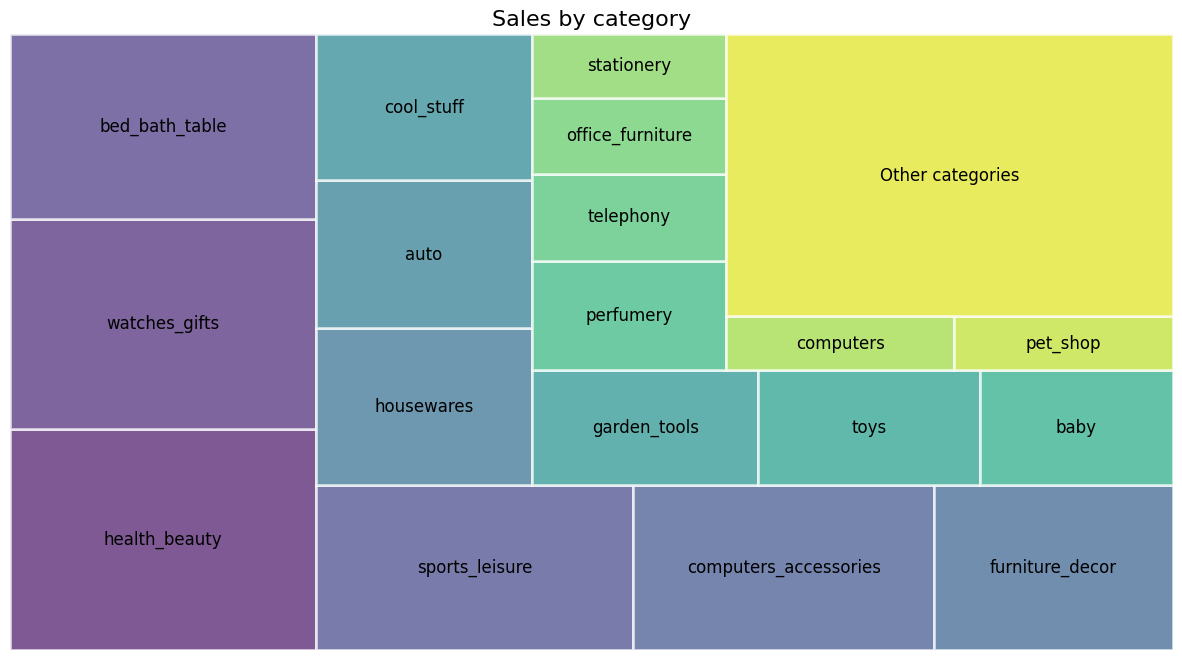

In [43]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

plt.figure(figsize=(15, 8))
plt.title('Sales by category')

color = sns.color_palette("viridis", len(df))

squarify.plot(sizes=df['sales'], label=df['category'],
              alpha=0.7, color=color, edgecolor="white", linewidth=2)

plt.axis('off')
plt.show()

# Sales Trend by Category



In [49]:
selected_categories = ('health_beauty', 'auto', 'toys',
                       'electronics', 'fashion_shoes')

monthly_sales_selected_categories = f"""
SELECT
    date_format(order_purchase_timestamp, 'yyyy-MM') AS year_month,
    SUM(CASE WHEN product_category_name_english = 'health_beauty' THEN price ELSE 0 END) AS health_beauty,
    SUM(CASE WHEN product_category_name_english = 'auto' THEN price ELSE 0 END) AS auto,
    SUM(CASE WHEN product_category_name_english = 'toys' THEN price ELSE 0 END) AS toys,
    SUM(CASE WHEN product_category_name_english = 'electronics' THEN price ELSE 0 END) AS electronics,
    SUM(CASE WHEN product_category_name_english = 'fashion_shoes' THEN price ELSE 0 END) AS fashion_shoes
FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    JOIN products ON order_items.product_id = products.product_id
    JOIN product_category_name_translation ON products.product_category_name = product_category_name_translation.product_category_name
WHERE order_purchase_timestamp >= '2017-01-01'
    AND product_category_name_english IN {selected_categories}
GROUP BY year_month
ORDER BY year_month
"""

df_spark = spark.sql(monthly_sales_selected_categories)
df = df_spark.toPandas()
df['year_month'] = pd.to_datetime(df['year_month'])
df = df.set_index('year_month')

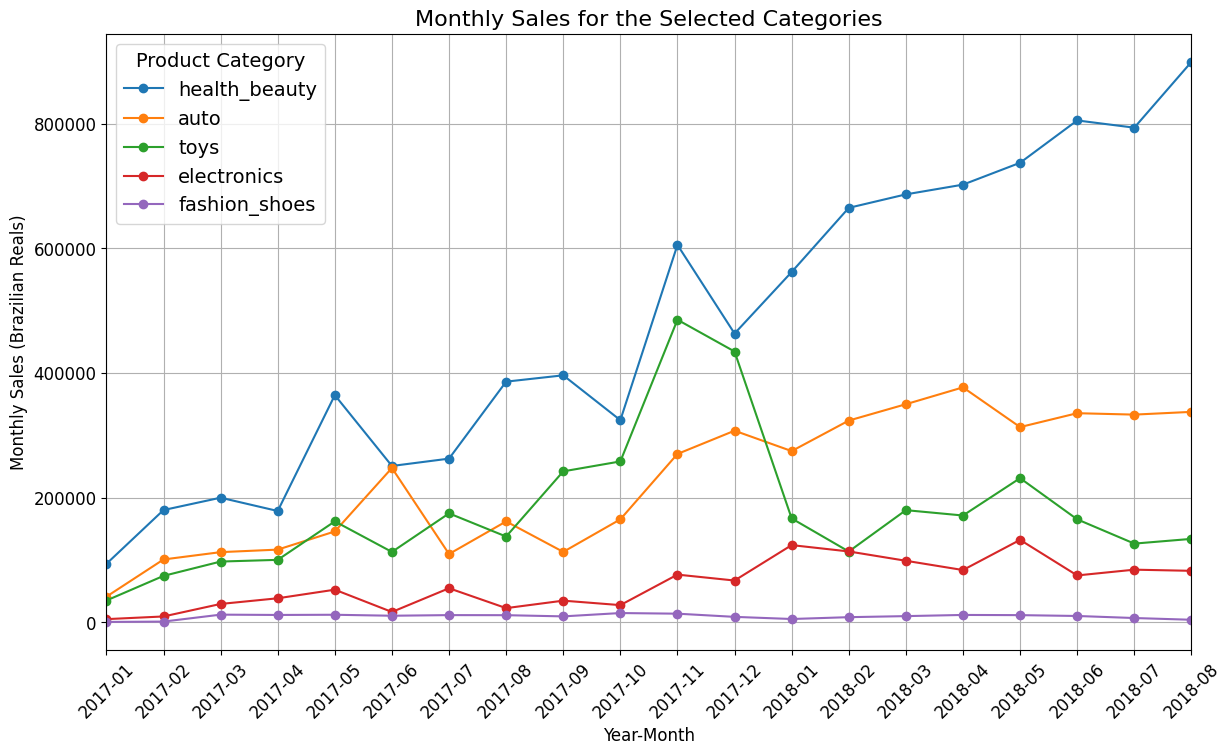

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))
df.plot(ax=ax, marker='o', linestyle='-')

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%Y-%m'), rotation=90)
plt.title('Monthly Sales for the Selected Categories')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Sales (Brazilian Reals)')
plt.xticks(rotation=45)
plt.legend(title='Product Category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

# Customer lifetime value in map view (Cluster View)



In [59]:
import numpy as np
import folium
# Example of registering dataframes as temporary views
df_customers.createOrReplaceTempView("customers")
df_orders.createOrReplaceTempView("orders")
df_order_payments.createOrReplaceTempView("order_payments")
df_geolocation.createOrReplaceTempView("geolocation")

# Now you can run the SQL queries

clv_query = """
WITH CustomerData AS (
    SELECT
        customer_unique_id,
        customer_zip_code_prefix AS zip_code_prefix,
        COUNT(DISTINCT o.order_id) AS order_count,
        SUM(op.payment_value) AS total_payment,
        MIN(o.order_purchase_timestamp) AS first_order_date,
        MAX(o.order_purchase_timestamp) AS last_order_date
    FROM customers c
    JOIN orders o ON c.customer_unique_id = o.customer_id
    JOIN order_payments op ON o.order_id = op.order_id
    GROUP BY customer_unique_id, customer_zip_code_prefix
)
SELECT
    customer_unique_id,
    zip_code_prefix,
    order_count AS PF,
    total_payment / order_count AS AOV,
    CASE
        WHEN DATEDIFF(last_order_date, first_order_date) < 7 THEN
            1
        ELSE
            DATEDIFF(last_order_date, first_order_date) / 7
        END AS ACL
FROM CustomerData

"""

avg_clv_query = """
WITH CLV AS (
    {clv_query}
)
SELECT
    zip_code_prefix AS zip_prefix,
    AVG(PF * AOV * ACL) AS avg_CLV,
    COUNT(customer_unique_id) AS customer_count,
    geolocation_lat AS latitude,
    geolocation_lng AS longitude
FROM CLV
JOIN geolocation g ON CLV.zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY zip_code_prefix, geolocation_lat, geolocation_lng
"""
clv_spark_df = spark.sql(clv_query)

avg_clv_query = avg_clv_query.format(clv_query=clv_query)
avg_clv_spark_df = spark.sql(avg_clv_query)

df_pandas = avg_clv_spark_df.toPandas()


map = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

for i, zip_prefix in df_pandas.iterrows():
    folium.CircleMarker(
        location=[zip_prefix['latitude'], zip_prefix['longitude']],
        radius=0.1 * np.sqrt(zip_prefix['customer_count']),
        color=None,
        fill_color='#85001d',
        fill_opacity=0.1 + 0.1 *
        np.sqrt(zip_prefix['avg_CLV'] / df_pandas['avg_CLV'].max()),
        popup=(
            f"<b>Zip Code Prefix:</b> {int(zip_prefix['zip_prefix'])}<br>"
            f"<b>Average CLV:</b> {int(zip_prefix['avg_CLV'])}<br>"
            f"<b>Customers:</b> {int(zip_prefix['customer_count'])}"
        )
    ).add_to(map)

map